# GNN Tutorial (PyG) — Solved

This notebook implements a GNN:
- loads the provided pickled NetworkX graphs (`graph_db.bin`),
- converts to PyG `Data` objects with node and edge features,
- splits into train/val/test,
- defines a simple GNN for binary graph classification,
- trains and evaluates it.

Dataset citation:

https://chrsmrrs.github.io/datasets/docs/home/
Riesen, K. and Bunke, H.: IAM Graph Database Repository for Graph Based Pattern Recognition and Machine Learning. In: da Vitora Lobo, N. et al. (Eds.), SSPR&SPR 2008, LNCS, vol. 5342, pp. 287-297, 2008.

AIDS Antiviral Screen Data (2004)


## Imports

In [ ]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00


In [ ]:
import os
import math
import pickle
import random
from typing import List

import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

try:
    import torch_geometric
    from torch_geometric.data import Data
    from torch_geometric.loader import DataLoader
    from torch_geometric.nn import global_mean_pool
except Exception as e:
    raise RuntimeError("PyTorch Geometric (torch_geometric) is required. Install via: pip install torch-geometric -f https://data.pyg.org/whl/torch-<torch_version>+cpu.html")

print('PyTorch:', torch.__version__)
print('PyG:', torch_geometric.__version__)


PyTorch: 2.8.0+cu126
PyG: 2.7.0


## NetworkX Star Graph (warm-up)

A tiny example to get comfortable with NetworkX: create and plot a star graph.


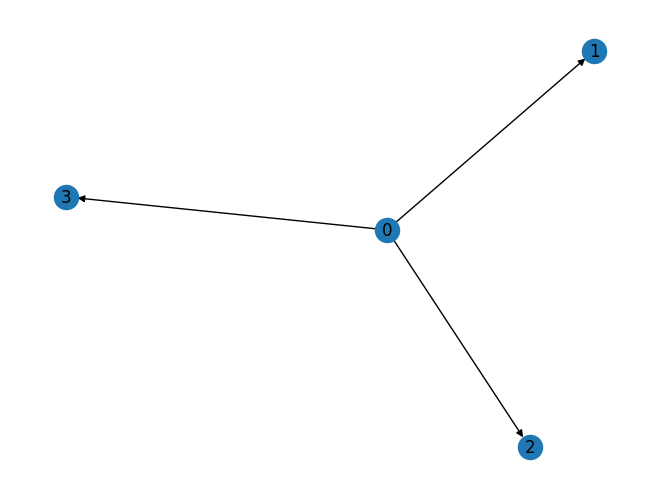

In [ ]:
# Create a directed star graph with 1 center and 3 leaves (manual construction, one statement each)
G_star = nx.DiGraph()
# Add nodes individually
G_star.add_node(0)  # center
G_star.add_node(1)
G_star.add_node(2)
G_star.add_node(3)
# Add directed edges individually (center -> leaves)
G_star.add_edge(0, 1)
G_star.add_edge(0, 2)
G_star.add_edge(0, 3)

nx.draw(G_star, with_labels=True, arrows=True)

plt.show()


## Utils: one-hot and conversion NetworkX -> PyG Data

In [ ]:
def to_one_hot(label: int, num_classes: int) -> List[float]:
    vec = np.zeros(num_classes, dtype=np.float32)
    vec[int(label)] = 1.0
    return vec.tolist()

def _as_class_index(val, num_classes):
    # Accept int, float, [single], or one-hot-like vectors
    arr = np.asarray(val)
    if arr.ndim == 0:
        return int(arr)
    arr = arr.reshape(-1)
    if arr.size == 1:
        return int(arr[0])
    # assume one-hot / score vector
    return int(np.argmax(arr))

def convert_nx_to_pyg_data(G: nx.Graph, num_node_label_classes: int = 38, num_edge_label_classes: int = 3) -> Data:
    # Node features: attributes + one-hot node label (as in the TF notebook)
    node_ids = list(G.nodes())
    node_ids_sorted = sorted(node_ids)
    nid_to_idx = {nid: i for i, nid in enumerate(node_ids_sorted)}
    node_features = []
    for nid in node_ids_sorted:
        attrs = np.asarray(G.nodes[nid]['attributes'], dtype=np.float32).tolist()
        nlab_raw = G.nodes[nid]['labels']
        nlab = _as_class_index(nlab_raw, num_node_label_classes)
        feat = np.asarray(list(attrs) + to_one_hot(nlab, num_node_label_classes), dtype=np.float32)
        node_features.append(feat)
    x = torch.tensor(np.stack(node_features, axis=0), dtype=torch.float32)  # [N, 42]

    # Edges: build edge_index (undirected -> add both directions) and edge_attr one-hot or passthrough
    src, dst, eattr = [], [], []
    for (u, v) in G.edges():
        elab_raw = G.edges[(u, v)]['labels']
        if isinstance(elab_raw, (list, tuple, np.ndarray)) and len(np.asarray(elab_raw).reshape(-1)) == num_edge_label_classes:
            one = np.asarray(elab_raw, dtype=np.float32)
        else:
            ei = _as_class_index(elab_raw, num_edge_label_classes)
            one = np.asarray(to_one_hot(ei, num_edge_label_classes), dtype=np.float32)
        ui = nid_to_idx[u]; vi = nid_to_idx[v]
        # add both directions
        src.append(ui); dst.append(vi); eattr.append(one)
        src.append(vi); dst.append(ui); eattr.append(one)
    edge_index = torch.tensor([src, dst], dtype=torch.long)  # [2, E*2]
    edge_attr = torch.tensor(np.stack(eattr, axis=0), dtype=torch.float32)  # [E*2, 3]

    # Graph label: accept int / [1] / one-hot
    y_raw = G.graph.get('classes', 0)
    y_scalar = float(_as_class_index(y_raw, 2))
    y = torch.tensor([y_scalar], dtype=torch.float32)  # BCEWithLogitsLoss expects float

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


## Load and preprocess data

### Download dataset (if missing)

In [ ]:
# Colab/Local: fetch graph_db.bin from Google Drive if not present
import os, shutil
if not os.path.exists('graph_db.bin'):
    print('Downloading graph_db.bin ...')
    # Same link used in the TF notebooks
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IHy7C6uZnAQucvW3jI-_fs6vAQfcn3HQ' -O graph_db.bin
else:
    print('graph_db.bin found, skipping download.')


--2025-10-20 17:44:41--  https://docs.google.com/uc?export=download&id=1IHy7C6uZnAQucvW3jI-_fs6vAQfcn3HQ
Resolving docs.google.com (docs.google.com)... 142.250.31.101, 142.250.31.138, 142.250.31.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.31.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1IHy7C6uZnAQucvW3jI-_fs6vAQfcn3HQ&export=download [following]
--2025-10-20 17:44:41--  https://drive.usercontent.google.com/download?id=1IHy7C6uZnAQucvW3jI-_fs6vAQfcn3HQ&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.62.132, 2607:f8b0:4004:c0b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.62.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2847517 (2.7M) [application/octet-stream]
Saving to: ‘graph_db.bin’

graph_db.bin        100%[===================>]   2.71M  --.-KB/s    in 

In [ ]:
def load_graphs_pickle(path: str, limit: int = -1) -> List[nx.Graph]:
    db = pickle.load(open(path, 'rb'))
    if limit is not None and limit > 0:
        db = db[:limit]
    return db

def nx_list_to_pyg(db: List[nx.Graph]) -> List[Data]:
    data_list = []
    for G in tqdm(db, desc='Converting to PyG'):
        data_list.append(convert_nx_to_pyg_data(G))
    return data_list

# Adjust the limit to -1 to load all once you're ready
graphs_nx = load_graphs_pickle('graph_db.bin', limit=-1)
data_list = nx_list_to_pyg(graphs_nx)
len(data_list), data_list[0]


Converting to PyG: 100%|██████████| 2000/2000 [00:01<00:00, 1096.23it/s]


(2000, Data(x=[47, 42], edge_index=[2, 106], edge_attr=[106, 3], y=[1]))

### Plot two samples with NetworkX (active vs inactive)

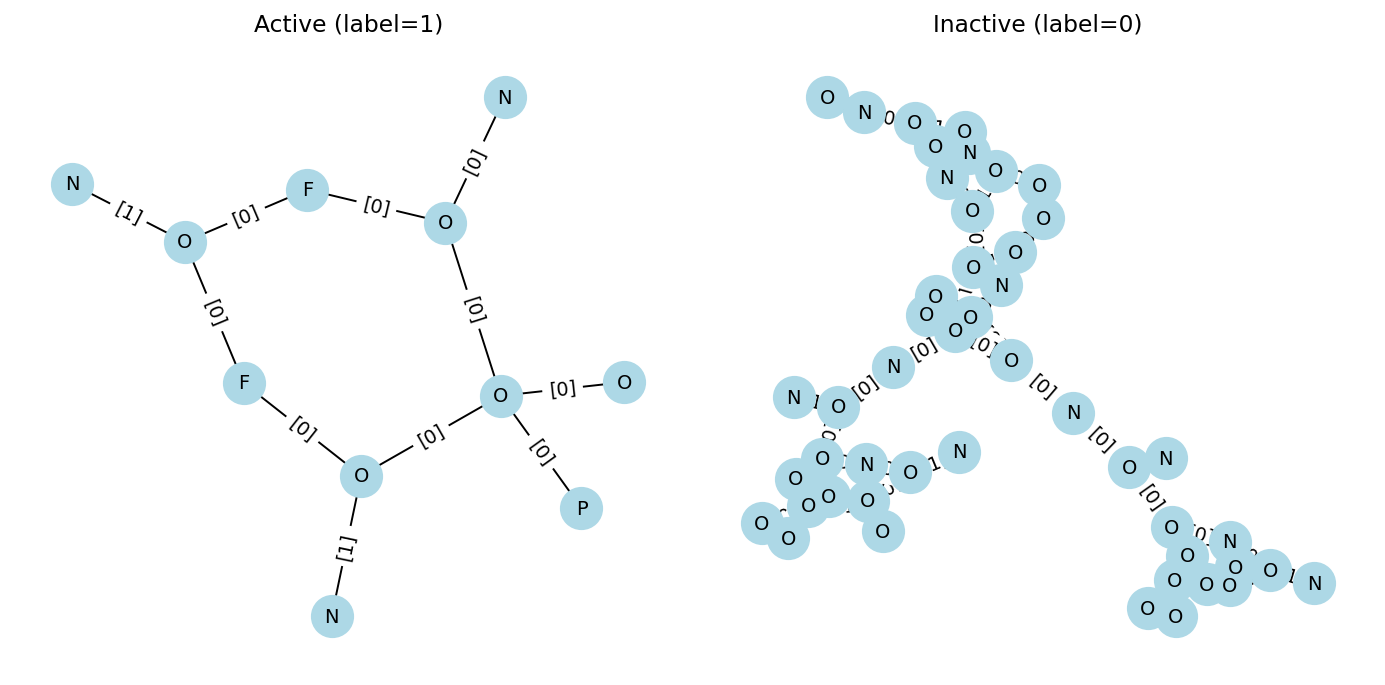

In [ ]:
import matplotlib.pyplot as plt

def plot_networkx_graph(G: nx.Graph, ax=None, title: str = 'Molecule'):
    numeric_to_str_atomic_codes = { 0: 'C',1: 'O',2: 'N',3: 'Cl',4: 'F',5: 'S',6: 'Se',7: 'P',8: 'Na',9: 'I',
                                    10: 'Co',11: 'Br',12: 'Li',13: 'Si',14: 'Mg',15: 'Cu',16: 'As',17: 'B',
                                    18: 'Pt',19: 'Ru',20: 'K',21: 'Pd',22: 'Au',23: 'Te',24: 'W',25: 'Rh',26: 'Zn',
                                    27: 'Bi',28: 'Pb',29: 'Ge',30: 'Sb',31: 'Sn',32: 'Ga',33: 'Hg',34: 'Ho',35: 'Tl',
                                    36: 'Ni',37: 'Tb'}
    if ax is None:
        ax = plt.gca()
    pos = nx.spring_layout(G, seed=0)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=450, ax=ax)
    attrs = nx.get_node_attributes(G, 'attributes')
    if attrs:
        node_label_atom = {k: numeric_to_str_atomic_codes.get(int(v[0]), str(int(v[0]))) for k, v in attrs.items()}
        nx.draw_networkx_labels(G, pos, labels=node_label_atom, font_size=10, ax=ax)
    elabs = nx.get_edge_attributes(G, 'labels')
    if elabs:
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(i,j): str(elabs[(i,j)]) for (i,j) in G.edges()}, ax=ax)
    ax.set_title(title)
    ax.axis('off')

# Helper to get binary class from graph meta (supports int or one-hot)
import numpy as _np

def get_label(G: nx.Graph) -> int:
    y = G.graph.get('classes', 0)
    arr = _np.asarray(y)
    if arr.ndim == 0:
        return int(arr)
    arr = arr.reshape(-1)
    if arr.size == 1:
        return int(arr[0])
    return int(arr.argmax())

# Pick one active (1) and one inactive (0) molecule
active = next((g for g in graphs_nx if get_label(g) == 1), graphs_nx[0])
inactive = next((g for g in graphs_nx if get_label(g) == 0), graphs_nx[-1])

# Plot side-by-side using subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=140)
plot_networkx_graph(active, ax=axs[0], title='Active (label=1)')
plot_networkx_graph(inactive, ax=axs[1], title='Inactive (label=0)')
plt.tight_layout()
plt.show()


## Train/Val/Test split

In [ ]:
def split_data(data_list: List[Data], seed: int = 42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(data_list))
    rng.shuffle(idx)
    n = len(idx)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    val_idx = idx[:n_val]
    test_idx = idx[n_val:n_val + n_test]
    train_idx = idx[n_val + n_test:]
    def take(ids): return [data_list[i] for i in ids]
    return take(train_idx), take(val_idx), take(test_idx)

train_data, val_data, test_data = split_data(data_list, seed=42)
len(train_data), len(val_data), len(test_data)


(1200, 400, 400)

## DataLoaders

In [ ]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
len(train_loader), len(val_loader), len(test_loader)


(38, 13, 13)

## PyTorch Primer: Simple CNN
A compact CNN example to illustrate core PyTorch patterns (modules, forward, tensors). No training here.


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels: int = 1, num_classes: int = 10):
        super().__init__()
        # Use ModuleList so students see the pattern
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
        ])
        self.pool = nn.MaxPool2d(2, 2)
        self.head = nn.Linear(32, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convs:
            x = F.relu(conv(x))
            x = self.pool(x)
        # Global average pool to remove spatial dims
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)  # [B, 32]
        logits = self.head(x)
        return logits

# Demo a forward pass on dummy data (e.g., MNIST-like 1x28x28)
cnn = SimpleCNN(in_channels=1, num_classes=10)
demo_x = torch.randn(4, 1, 28, 28)
demo_logits = cnn(demo_x)
print('Output shape:', demo_logits.shape)


Output shape: torch.Size([4, 10])


## Model (MPNN-style)

In [ ]:
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

class MPNNLayer(MessagePassing):
    def __init__(self, hidden: int, edge_dim: int, dropout: float = 0.0, aggr: str = 'add'):
        super().__init__(aggr=aggr)
        self.dropout = 0.5
        # Message MLP: [h_j, e_ij, h_i] -> m_ij
        self.m1 = nn.Linear(hidden + edge_dim + hidden, hidden)
        self.m_drop = nn.Dropout(dropout)
        self.m2 = nn.Linear(64, 64)
        # Update MLP: [h_i, m_i] -> h_i'
        self.u1 = nn.Linear(hidden + hidden, hidden)
        self.u_drop = nn.Dropout(dropout)
        self.u2 = nn.Linear(64, 64)

    def forward(self, h: torch.Tensor, edge_index: Adj, e_wv: torch.Tensor):
        return self.propagate(edge_index, h=h, e_wv=e_wv)

    def message(self, h_i: torch.Tensor, h_j: torch.Tensor, e_wv: torch.Tensor) -> torch.Tensor:
        # h_j ≡ h_w (source), h_i ≡ h_v (target), e_wv ≡ e_{wv}
        m_in = torch.cat([h_j, e_wv, h_i], dim=-1)
        m = F.relu(self.m1(m_in))
        m = self.m_drop(m)
        m = self.m2(m)
        return m

    def update(self, aggr_out: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        u_in = torch.cat([h, aggr_out], dim=-1)
        h = F.relu(self.u1(u_in))
        h = self.u_drop(h)
        h = self.u2(h)
        return h

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = 0.5
        self.edge_dim = 3
        self.input_node_dim = 42
        self.lin_in = nn.Linear(self.input_node_dim, 64)
        self.convs = nn.ModuleList([MPNNLayer(hidden=64, edge_dim=self.edge_dim, dropout=0.5) for _ in range(3)])
        # Readout head without Sequential
        self.out1 = nn.Linear(64, 64)
        self.out_drop = nn.Dropout(self.dropout)
        self.out2 = nn.Linear(64, 1)

    def forward(self, data: Data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.lin_in(x)
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        x = F.relu(self.out1(x))
        x = self.out_drop(x)
        out = self.out2(x).squeeze(-1)  # [B]
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
model


GNN(
  (lin_in): Linear(in_features=42, out_features=64, bias=True)
  (convs): ModuleList(
    (0-2): 3 x MPNNLayer()
  )
  (out1): Linear(in_features=64, out_features=64, bias=True)
  (out_drop): Dropout(p=0.5, inplace=False)
  (out2): Linear(in_features=64, out_features=1, bias=True)
)

## Train and evaluate

In [ ]:
def bce_logits_loss():
    return nn.BCEWithLogitsLoss()

def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    with torch.no_grad():
        preds = (logits.sigmoid() > 0.5).float()
        # y can be shape [B] float; ensure same
        yb = y.view_as(preds)
        correct = (preds == yb).float().sum().item()
        total = preds.numel()
        return correct / max(total, 1)

def train_one_epoch(model, loader, opt, criterion):
    model.train()
    total_loss, total_acc, total_count = 0.0, 0.0, 0
    for batch in loader:
        batch = batch.to(device)
        opt.zero_grad()
        logits = model(batch)  # [B]
        y = batch.y.view(-1).to(device)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * y.size(0)
        total_acc += accuracy_from_logits(logits, y) * y.size(0)
        total_count += y.size(0)
    return total_loss / max(total_count, 1), total_acc / max(total_count, 1)

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc, total_count = 0.0, 0.0, 0
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)
        y = batch.y.view(-1).to(device)
        loss = criterion(logits, y)
        total_loss += loss.item() * y.size(0)
        total_acc += accuracy_from_logits(logits, y) * y.size(0)
        total_count += y.size(0)
    return total_loss / max(total_count, 1), total_acc / max(total_count, 1)

# Training config
epochs = 20
lr = 1e-4
criterion = bce_logits_loss()
optimizer = Adam(model.parameters(), lr=lr)

# Track metrics over epochs for plotting
history = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc = evaluate(model, val_loader, criterion)

    # save metrics
    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(va_loss)
    history['val_acc'].append(va_acc)

    print(f'Epoch {ep:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}')


Epoch 01 | train loss 0.6938 acc 0.487 | val loss 0.6843 acc 0.772
Epoch 02 | train loss 0.6642 acc 0.780 | val loss 0.6451 acc 0.772
Epoch 03 | train loss 0.5684 acc 0.804 | val loss 0.5434 acc 0.772
Epoch 04 | train loss 0.4811 acc 0.804 | val loss 0.4766 acc 0.772
Epoch 05 | train loss 0.4367 acc 0.804 | val loss 0.4493 acc 0.772
Epoch 06 | train loss 0.4163 acc 0.804 | val loss 0.4287 acc 0.772
Epoch 07 | train loss 0.4045 acc 0.804 | val loss 0.4098 acc 0.772
Epoch 08 | train loss 0.3804 acc 0.804 | val loss 0.3968 acc 0.772
Epoch 09 | train loss 0.3601 acc 0.804 | val loss 0.3726 acc 0.772
Epoch 10 | train loss 0.3501 acc 0.804 | val loss 0.3533 acc 0.772
Epoch 11 | train loss 0.3257 acc 0.804 | val loss 0.3376 acc 0.772
Epoch 12 | train loss 0.3102 acc 0.804 | val loss 0.3170 acc 0.772
Epoch 13 | train loss 0.2989 acc 0.817 | val loss 0.3023 acc 0.800
Epoch 14 | train loss 0.2863 acc 0.836 | val loss 0.2926 acc 0.835
Epoch 15 | train loss 0.2767 acc 0.853 | val loss 0.2870 acc 0

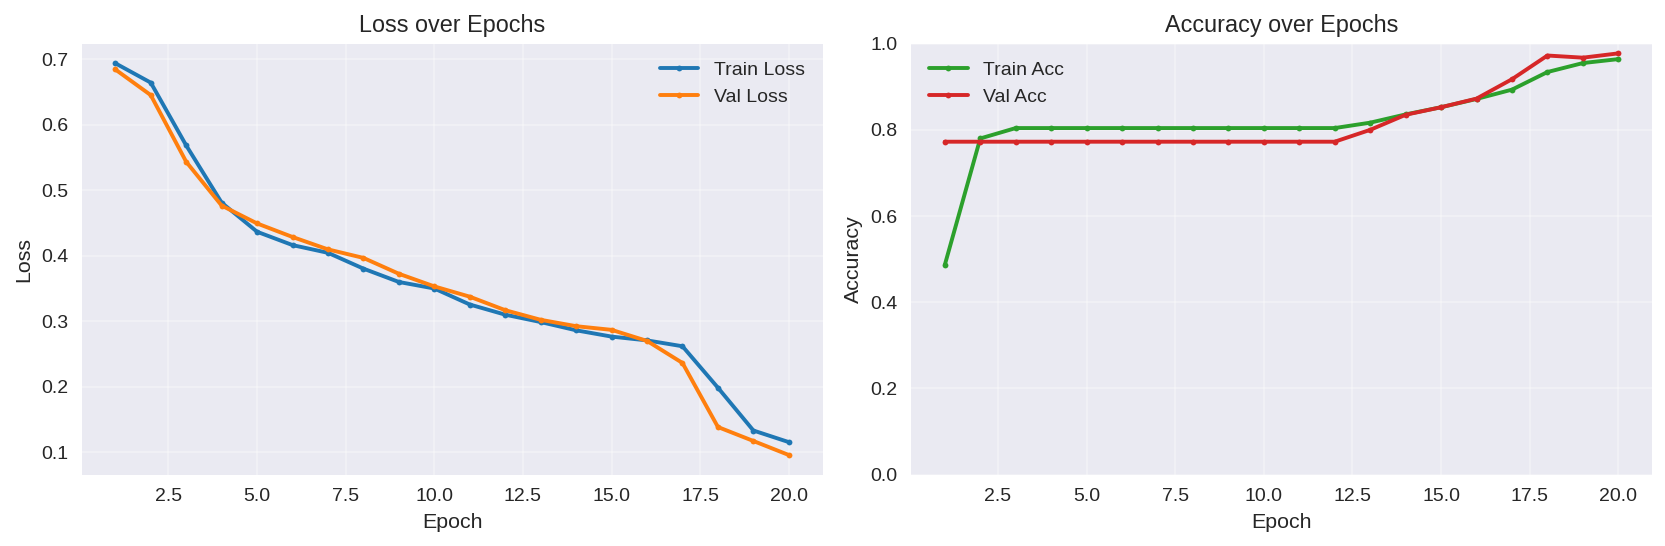

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=140)
epochs_range = range(1, epochs + 1)
# Loss
axs[0].plot(epochs_range, history['train_loss'], label='Train Loss', color='#1f77b4', marker='o', linewidth=2, markersize=3)
axs[0].plot(epochs_range, history['val_loss'], label='Val Loss', color='#ff7f0e', marker='o', linewidth=2, markersize=3)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over Epochs')
axs[0].grid(True, alpha=0.3)
axs[0].legend(frameon=False)
# Accuracy
axs[1].plot(epochs_range, history['train_acc'], label='Train Acc', color='#2ca02c', marker='o', linewidth=2, markersize=3)
axs[1].plot(epochs_range, history['val_acc'], label='Val Acc', color='#d62728', marker='o', linewidth=2, markersize=3)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim(0.0, 1.0)
axs[1].set_title('Accuracy over Epochs')
axs[1].grid(True, alpha=0.3)
axs[1].legend(frameon=False)
plt.tight_layout()
plt.show()


## Test set evaluation (optional)

In [ ]:
te_loss, te_acc = evaluate(model, test_loader, criterion)
print(f'Test loss {te_loss:.4f} acc {te_acc:.3f}')


Test loss 0.0603 acc 0.985
